# **02807 Computational Tools for Data Science**
## **Final Project**


In [14]:
import pandas as pd
data = pd.read_csv("../data/fake reviews dataset.csv")
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [15]:
data.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [16]:
data['rating'].value_counts()

rating
5    24559
4     7965
3     3786
1     2155
2     1967
Name: count, dtype: int64

## **Text Similarity Analyzis**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re


# Define a text cleaning function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
data['cleaned_text'] = data['text_'].apply(clean_text)

# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [18]:
import numpy as np

# Find pairs with high similarity scores
similar_pairs = []
threshold = 0.9  # Adjust as needed

for i in range(len(data)):
    for j in range(i + 1, len(data)):
        if cosine_sim_matrix[i, j] > threshold:
            similar_pairs.append((i, j, cosine_sim_matrix[i, j]))

# Display similar pairs
for i, j, score in similar_pairs:
    print(f"Review {i} and Review {j} have similarity score: {score:.2f}")
    print(f"Review {i}: {data['text_'].iloc[i]}")
    print(f"Review {j}: {data['text_'].iloc[j]}\n")

Review 138 and Review 1065 have similarity score: 1.00
Review 138: Happy with my purchase.  We have had the same mattress for a few months now and this one
Review 1065: Very happy with purchase.  We have had the same mattress for a few months now and have not had a

Review 143 and Review 725 have similarity score: 1.00
Review 143: Easy to put together and looks nice and the finish is good.  I have a large one and
Review 725: Easy to put together and looks nice and the finish is good.  I have a large one and

Review 403 and Review 809 have similarity score: 1.00
Review 403: I bought this as a gift for my daughter and she loved it.  It's been a great
Review 809: We bought this as a gift for my daughter and she loved it.  It's been a great

Review 983 and Review 5626 have similarity score: 0.92
Review 983: This seems to be well made. The only problem is that it comes with a small screw driver.
Review 5626: Easy to put up and down. The only problem is that it comes with a small screw drive

### **Local Sensitivity Hashing**

**Create MinHash Signatures**

In [19]:
from datasketch import MinHash, MinHashLSH

# Define a function to create MinHash signature for each review
def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode('utf8'))
    return m

# Create MinHash signatures for each cleaned review
data['minhash'] = data['cleaned_text'].apply(get_minhash)

**Set Up Locality-Sensitive Hashing (LSH)**

In [20]:
# Initialize LSH with a threshold for similarity (e.g., 0.8)
lsh = MinHashLSH(threshold=0.8, num_perm=128)

# Insert each review's MinHash into LSH
for idx, minhash in enumerate(data['minhash']):
    lsh.insert(f"review_{idx}", minhash)

**Query for Similar Reviews**

In [21]:
# Find similar reviews for each review and display them
similar_pairs = []
for idx, minhash in enumerate(data['minhash']):
    # Query for similar items in LSH
    result = lsh.query(minhash)
    # Filter out self-match and add to pairs
    for match in result:
        if match != f"review_{idx}":
            similar_pairs.append((f"review_{idx}", match))

# Display similar pairs
for pair in similar_pairs:
    print(f"{pair[0]} is similar to {pair[1]}")

review_22 is similar to review_748
review_23 is similar to review_36833
review_23 is similar to review_132
review_44 is similar to review_334
review_132 is similar to review_36833
review_132 is similar to review_23
review_143 is similar to review_725
review_334 is similar to review_44
review_403 is similar to review_809
review_422 is similar to review_15593
review_439 is similar to review_663
review_501 is similar to review_900
review_520 is similar to review_8849
review_523 is similar to review_37230
review_572 is similar to review_20781
review_572 is similar to review_20053
review_663 is similar to review_439
review_725 is similar to review_143
review_748 is similar to review_22
review_808 is similar to review_1216
review_808 is similar to review_4733
review_809 is similar to review_403
review_900 is similar to review_501
review_905 is similar to review_1128
review_955 is similar to review_15773
review_955 is similar to review_16443
review_955 is similar to review_16100
review_983 is

## **Text Classification (Fake vs. Genuine Reviews)**

**Preprocess the Text Data**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.3, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

**Train a Classifier**

In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

**Evaluate the Model**

In [24]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = classifier.predict(X_test_tfidf)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8583676834295136
Classification Report:
               precision    recall  f1-score   support

          CG       0.87      0.84      0.86      6066
          OR       0.85      0.87      0.86      6064

    accuracy                           0.86     12130
   macro avg       0.86      0.86      0.86     12130
weighted avg       0.86      0.86      0.86     12130



**Precision:** The proportion of reviews classified as fake that are actually fake.\
**Recall:** The proportion of actual fake reviews that were correctly classified.\
**F1-score:** The balance between precision and recall, providing a single metric for classification performance.

## **Common Words in Fake vs. Genuine Reviews**

**Preprocess the Dataset**

In [28]:
# Separate fake and genuine reviews
fake_reviews = data[data['label'] == 'OR']['cleaned_text']
genuine_reviews = data[data['label'] == 'CG']['cleaned_text']

**Tokenize and Count Words**

In [31]:
from collections import Counter

# Tokenize and count words in fake reviews
fake_word_counts = Counter(" ".join(fake_reviews).split())

# Tokenize and count words in genuine reviews
genuine_word_counts = Counter(" ".join(genuine_reviews).split())

# Get the most common words in each category
common_fake_words = fake_word_counts.most_common(20)
common_genuine_words = genuine_word_counts.most_common(20)

# Display the most common words
print("Most common words in fake reviews:", common_fake_words)
print("Most common words in genuine reviews:", common_genuine_words)

Most common words in fake reviews: [('the', 73463), ('and', 44383), ('a', 40061), ('i', 39996), ('to', 37934), ('it', 30900), ('of', 25149), ('is', 24331), ('this', 22432), ('for', 18572), ('in', 18465), ('that', 14400), ('my', 13276), ('with', 12851), ('but', 11823), ('was', 11639), ('on', 10932), ('you', 10070), ('have', 9891), ('not', 9598)]
Most common words in genuine reviews: [('the', 83965), ('i', 56906), ('a', 56906), ('and', 43236), ('is', 40469), ('it', 37720), ('to', 30608), ('this', 26742), ('of', 20404), ('for', 20358), ('very', 14753), ('was', 14660), ('have', 13322), ('that', 12262), ('my', 11391), ('in', 11129), ('with', 10804), ('great', 10645), ('are', 10190), ('book', 9783)]


**Visualize the Word Frequencies**

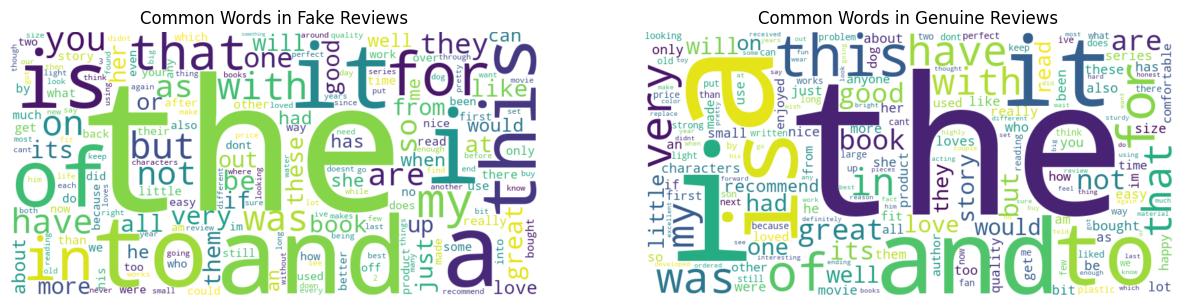

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_word_counts)
genuine_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genuine_word_counts)

# Plot word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation="bilinear")
plt.title("Common Words in Fake Reviews")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(genuine_wordcloud, interpolation="bilinear")
plt.title("Common Words in Genuine Reviews")
plt.axis("off")

plt.show()

**Import Stop Words**

In [33]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joninamatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Filter Out Stop Words**

In [34]:
# Clean and filter stop words from the text data
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(filtered_words)

# Apply text cleaning and filtering
data['cleaned_text'] = data['text_'].apply(clean_text)

**Tokenize and Count Words Again**

In [35]:
from collections import Counter

# Separate fake and genuine reviews
fake_reviews = data[data['label'] == 'OR']['cleaned_text']
genuine_reviews = data[data['label'] == 'CG']['cleaned_text']

# Tokenize and count words in fake reviews
fake_word_counts = Counter(" ".join(fake_reviews).split())

# Tokenize and count words in genuine reviews
genuine_word_counts = Counter(" ".join(genuine_reviews).split())

# Get the most common words in each category
common_fake_words = fake_word_counts.most_common(20)
common_genuine_words = genuine_word_counts.most_common(20)

# Display the most common words
print("Most common words in fake reviews:", common_fake_words)
print("Most common words in genuine reviews:", common_genuine_words)

Most common words in fake reviews: [('one', 6810), ('great', 5774), ('like', 5241), ('book', 5218), ('good', 4744), ('would', 4325), ('well', 4217), ('love', 3942), ('really', 3534), ('get', 3524), ('read', 3259), ('use', 2978), ('time', 2897), ('story', 2865), ('much', 2852), ('little', 2826), ('dont', 2481), ('also', 2360), ('first', 2160), ('even', 2113)]
Most common words in genuine reviews: [('great', 10645), ('book', 9783), ('good', 9451), ('love', 6863), ('story', 6761), ('one', 6585), ('well', 6061), ('would', 6037), ('read', 5609), ('little', 5318), ('recommend', 4765), ('characters', 4696), ('like', 4184), ('movie', 4096), ('bought', 3981), ('loves', 3639), ('small', 3466), ('also', 3361), ('im', 3164), ('nice', 3116)]


**Visualize**

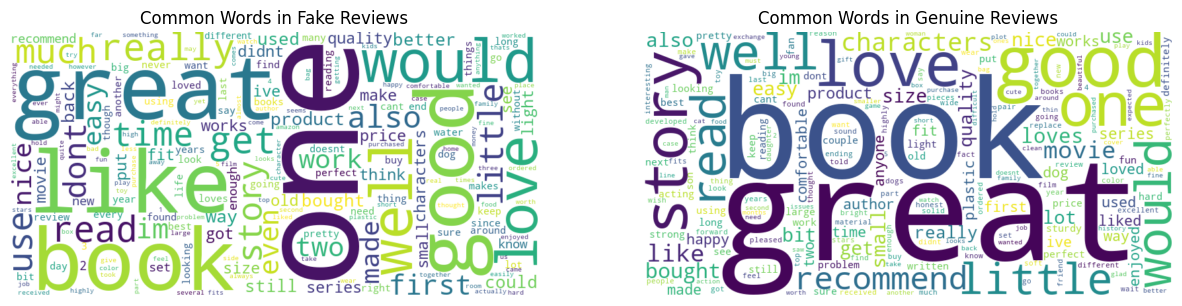

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_word_counts)
genuine_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genuine_word_counts)

# Plot word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation="bilinear")
plt.title("Common Words in Fake Reviews")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(genuine_wordcloud, interpolation="bilinear")
plt.title("Common Words in Genuine Reviews")
plt.axis("off")

plt.show()

### **Most common words within each category**

**Analyze Word Frequency by Category and Label**

In [37]:
# Get unique categories
categories = data['category'].unique()

# Dictionary to store common words by category and label
common_words_by_category = {}

for category in categories:
    # Filter reviews by category
    category_data = data[data['category'] == category]
    
    # Separate fake and genuine reviews in this category
    fake_reviews = category_data[category_data['label'] == 'OR']['cleaned_text']
    genuine_reviews = category_data[category_data['label'] == 'CG']['cleaned_text']
    
    # Count word frequencies for fake reviews
    fake_word_counts = Counter(" ".join(fake_reviews).split())
    common_fake_words = fake_word_counts.most_common(20)
    
    # Count word frequencies for genuine reviews
    genuine_word_counts = Counter(" ".join(genuine_reviews).split())
    common_genuine_words = genuine_word_counts.most_common(20)
    
    # Store the results
    common_words_by_category[category] = {
        'fake': common_fake_words,
        'genuine': common_genuine_words
    }

# Display the common words by category
for category, words in common_words_by_category.items():
    print(f"\nCategory: {category}")
    print("Most common words in fake reviews:", words['fake'])
    print("Most common words in genuine reviews:", words['genuine'])



Category: Home_and_Kitchen_5
Most common words in fake reviews: [('one', 635), ('great', 606), ('use', 525), ('like', 506), ('would', 464), ('well', 431), ('good', 420), ('love', 401), ('get', 352), ('easy', 330), ('nice', 319), ('really', 303), ('little', 303), ('product', 298), ('time', 291), ('much', 260), ('used', 254), ('made', 252), ('also', 251), ('dont', 243)]
Most common words in genuine reviews: [('great', 1068), ('love', 829), ('one', 796), ('would', 659), ('bought', 623), ('use', 615), ('nice', 615), ('easy', 613), ('good', 543), ('little', 513), ('small', 478), ('like', 450), ('quality', 445), ('also', 424), ('product', 416), ('size', 414), ('happy', 382), ('plastic', 379), ('well', 378), ('used', 367)]

Category: Sports_and_Outdoors_5
Most common words in fake reviews: [('great', 672), ('one', 563), ('good', 509), ('well', 502), ('like', 492), ('use', 466), ('would', 441), ('get', 391), ('fit', 336), ('dont', 314), ('really', 291), ('nice', 280), ('used', 280), ('product

**Visualize Results**

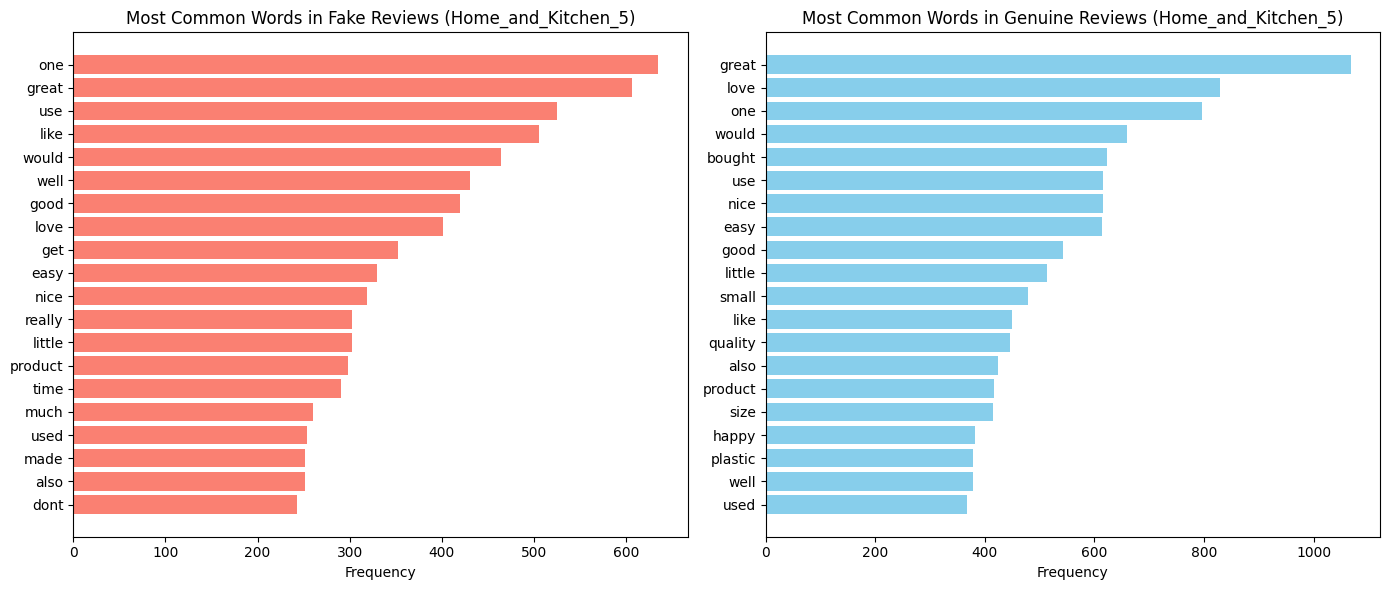

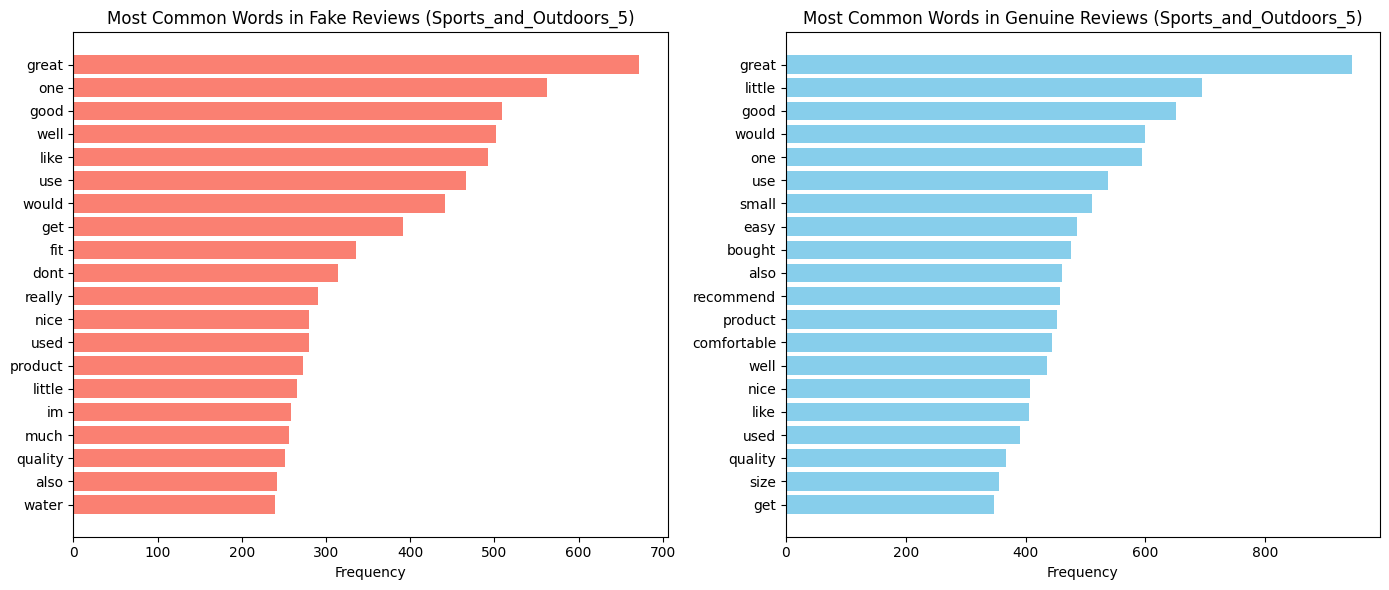

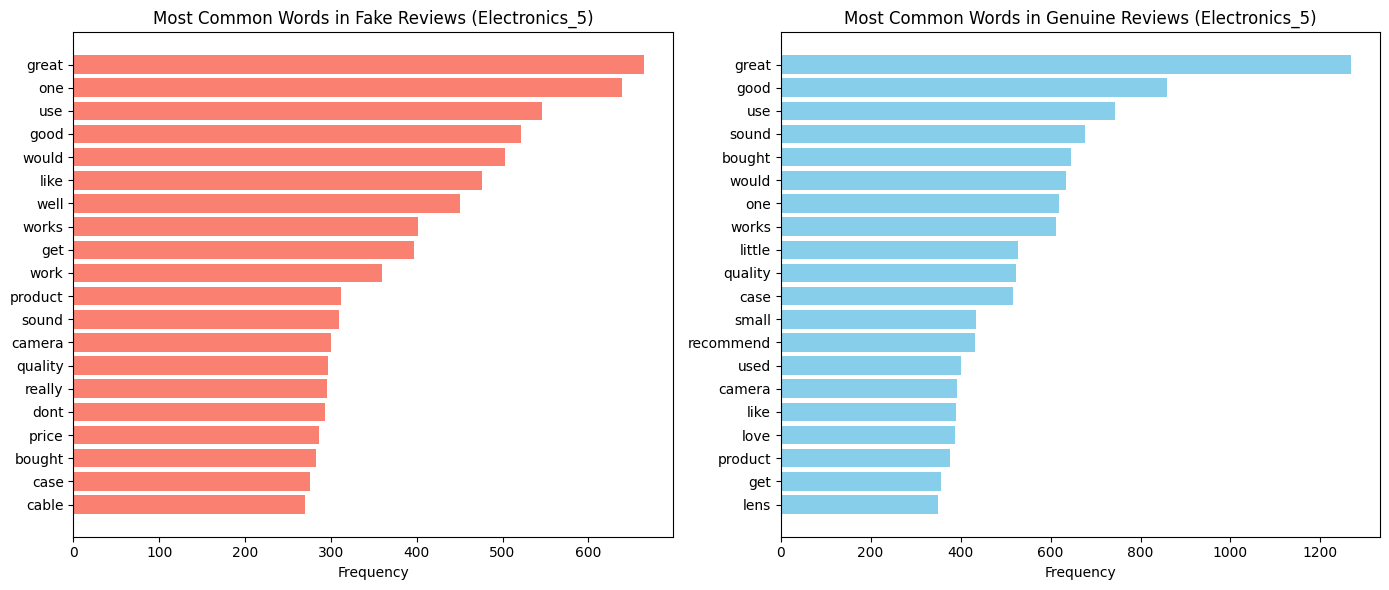

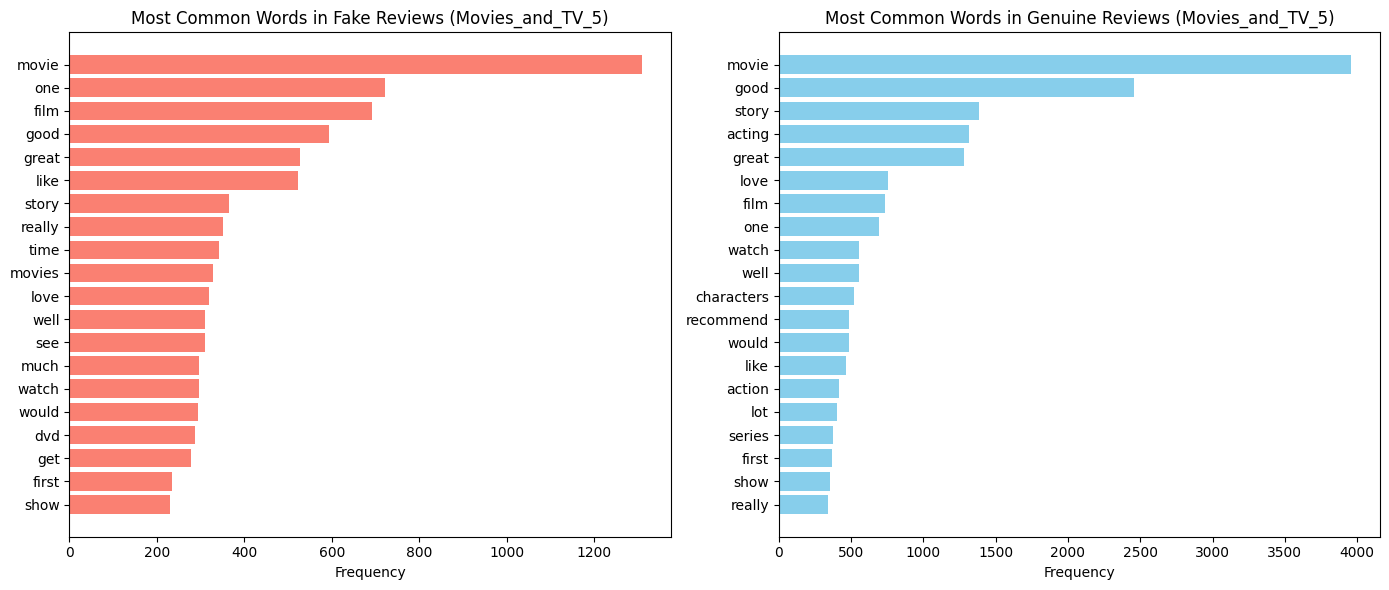

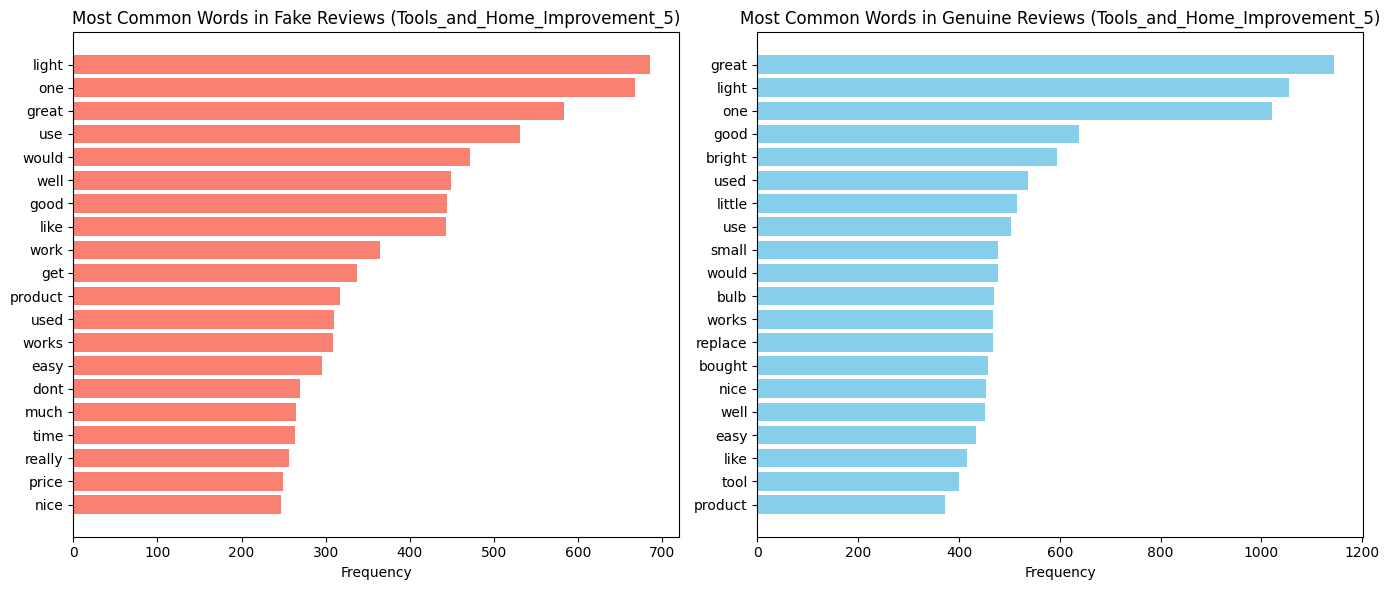

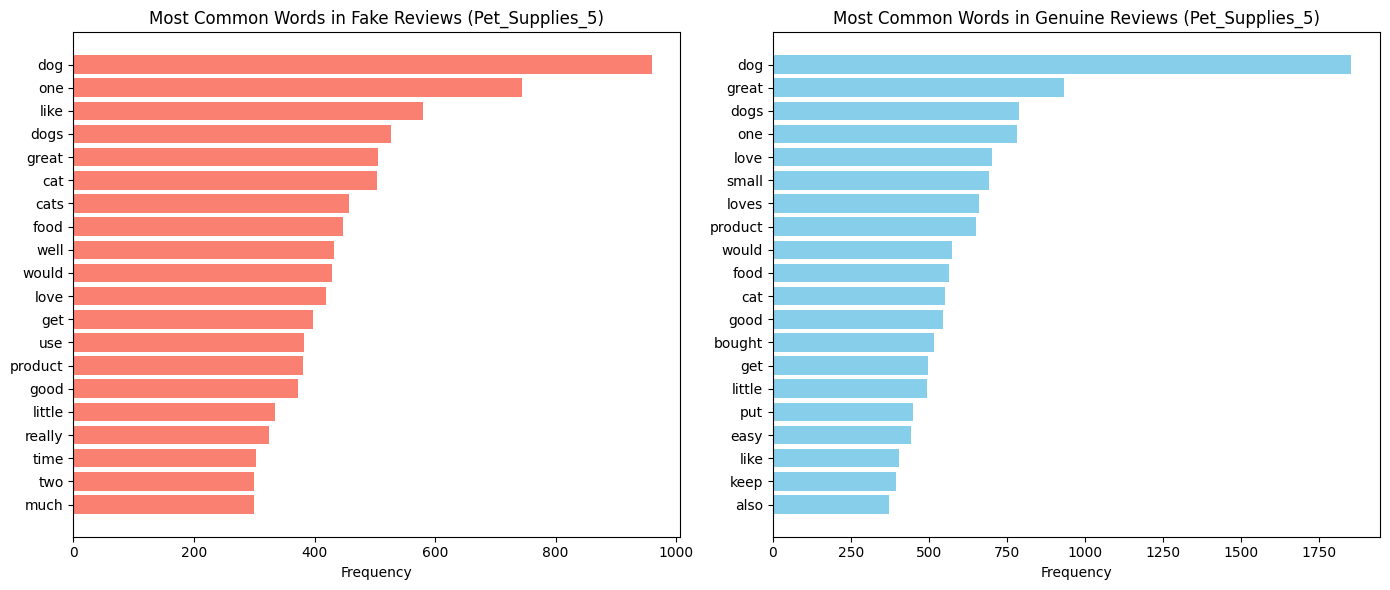

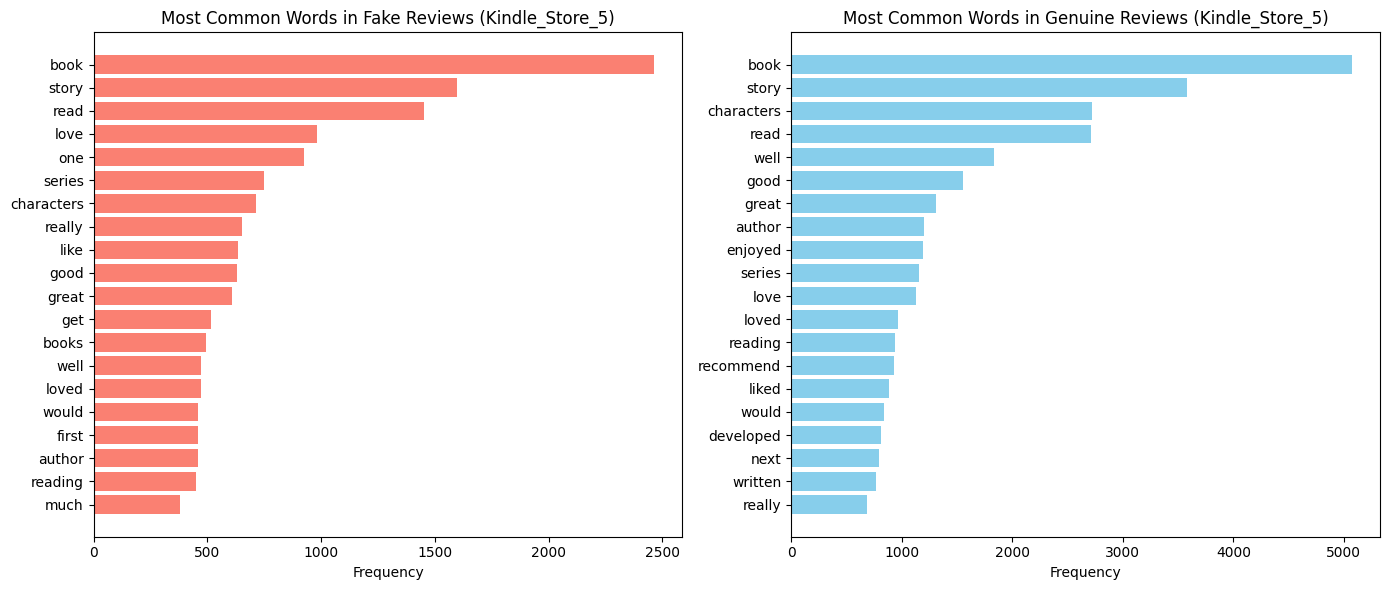

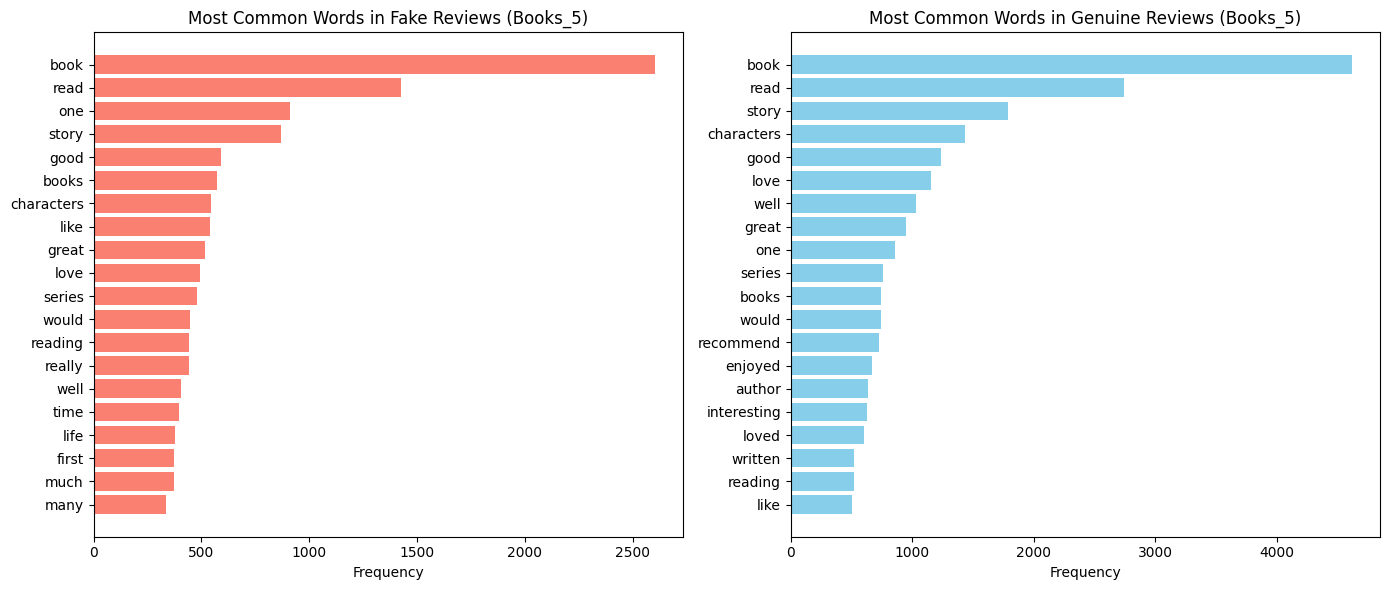

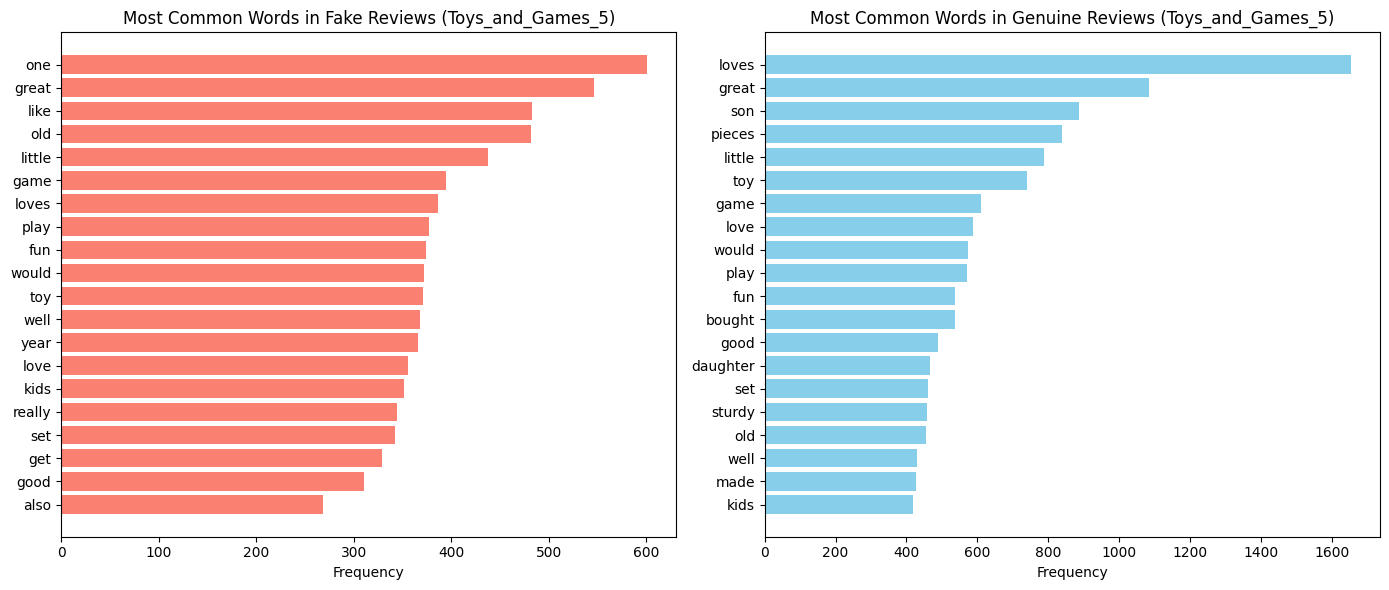

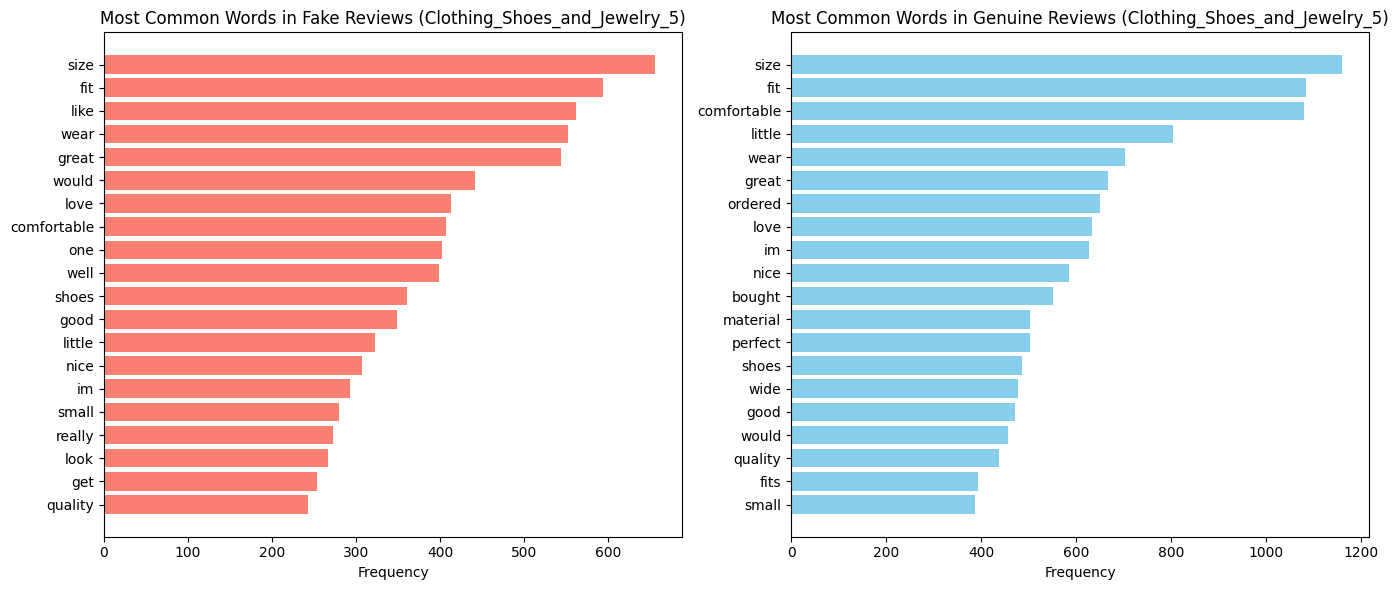

In [38]:
import matplotlib.pyplot as plt

for category, words in common_words_by_category.items():
    # Get word counts for fake and genuine reviews
    fake_words, fake_counts = zip(*words['fake'])
    genuine_words, genuine_counts = zip(*words['genuine'])

    # Plot bar charts
    plt.figure(figsize=(14, 6))

    # Fake reviews bar chart
    plt.subplot(1, 2, 1)
    plt.barh(fake_words, fake_counts, color='salmon')
    plt.title(f"Most Common Words in Fake Reviews ({category})")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()

    # Genuine reviews bar chart
    plt.subplot(1, 2, 2)
    plt.barh(genuine_words, genuine_counts, color='skyblue')
    plt.title(f"Most Common Words in Genuine Reviews ({category})")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
